In [1]:
import dask
import intake
import pandas as pd
import xarray


**Read in catalog and initialize dataset**

In [2]:
catalog = intake.open_catalog("s3://noaa-nos-cora-pds/CORA_intake.yml")
print(list(catalog))

['CORA-V1-fort.63', 'CORA-V1-maxele.63', 'CORA-V1-fort.64', 'CORA-V1-500m-grid-1979-2022']


In [4]:
ds = catalog['CORA-V1-fort.63'].to_dask()
ds

<xarray.Dataset>
Dimensions:      (mesh: 1, node: 1813443, nele: 3564104, nvertex: 3, nbou: 186,
                  nope: 1, neta_dim: 186, nvel_dim: 62972, time: 385704)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2022-12-31T23:00:00
    x            (node) float64 dask.array<chunksize=(160000,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(160000,), meta=np.ndarray>
Dimensions without coordinates: mesh, node, nele, nvertex, nbou, nope,
                                neta_dim, nvel_dim
Data variables: (12/14)
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    depth        (node) float64 dask.array<chunksize=(160000,), meta=np.ndarray>
    element      (nele, nvertex) int32 dask.array<chunksize=(3564104, 3), meta=np.ndarray>
    ibtype       (nbou) int32 dask.array<chunksize=(186,), meta=np.ndarray>
    ibtypee      (nope) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    max_nvdll    float64 ...
    ...           ...
    nbvv         (nvel_dim) int32 dask.array<chunksize=(62972,), meta=np.ndarray>
    neta         float64 ...
    nvdll        (nope) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvel         float64 ...
    nvell        (nbou) int32 dask.array<chunksize=(186,), meta=np.ndarray>
    zeta         (time, node) float64 dask.array<chunksize=(240, 160000), meta=np.ndarray>
Attributes: (12/49)
    Conventions:        UGRID-0.9.0
    NCO:                netCDF Operators version 4.7.5 (Homepage = http://nco...
    a00:                0.0
    agrid:              NOMAD mesh v1e MSL - fixed bahamas bathy
    b00:                1.0
    c00:                0.0
    ...                 ...
    slam0:              265.5
    source:             RENCI_HPC
    statim:             0.0
    tau0:               -3.0
    title:              NOAA-Reanalysis-Post
    version:            noaa.stofs.2d.glo.v1.1.0r2-21-g7052115

<br/>**Create the kdtree to be used for fast location lookups**<br/>
This function uses the lat/lon values defined in ds to create a kdtree

In [5]:
%run shared/setup_kdtree.ipynb
tree, areas, e, x_vals, y_vals = define_kd_tree(ds)

<br/>**Define the locations to extract data**

In [6]:
d = {"lat": [30.123363, 30.128206], "lon": [-81.67663, -81.64425]}
df = pd.DataFrame(data=d)
print("Number of locations=", len(df.lon))

Number of locations= 2


<br/>**Determines the nodes for each point that should be extracted**

In [7]:
%run find_node_triangle.ipynb # where find_triangle is defined

nodes = len(df.lon)
t_indices = np.zeros(shape=(nodes), dtype=int)
weights = np.zeros(shape=((nodes, 3)), dtype=float)
triangle_arr = np.zeros(shape=((nodes, 3)), dtype=int)

for i in range(0, nodes):
    t_indices[i] = find_triangle(x_vals, y_vals, e, df.lat[i], df.lon[i])

    triangle_arr[i, :] = e[t_indices[i]]
    x_dist = df.lon[i] - x_vals[triangle_arr[i, :]]
    y_dist = df.lat[i] - y_vals[triangle_arr[i, :]]
    dist = np.sqrt(x_dist * x_dist + y_dist * y_dist)
    if np.any(dist == 0):

        weights[i, :] = np.where(dist == 0, 1, 0)
    else:
        weights[i, :] = 1 / dask.array.sqrt(x_dist * x_dist + y_dist * y_dist)


unique_nodes = np.unique(triangle_arr)
mapped_triangle = np.searchsorted(unique_nodes, triangle_arr)

<br/>**Extract a timeseries at each location**

CPU times: user 6.82 s, sys: 4.16 s, total: 11 s
Wall time: 12.8 s


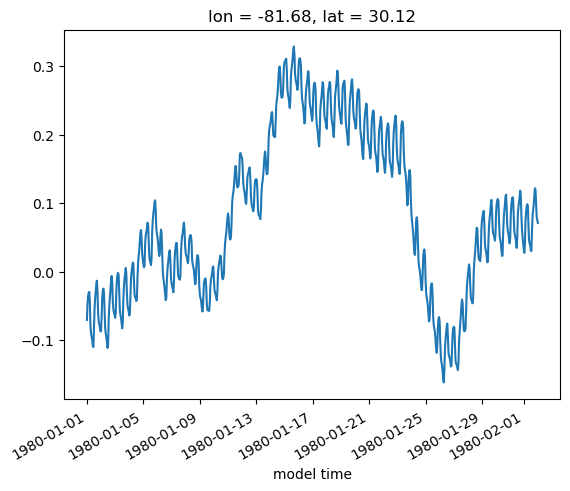

In [9]:
%%time
start_t = "1980-01-01"
end_t = "1980-02-01"
var_name = "zeta"

zeta_tslice = ds[var_name].sel(time=slice(start_t, end_t), node=unique_nodes).compute()

num_ts = len(zeta_tslice)
nodes = len(mapped_triangle)

t = np.zeros((num_ts, nodes, 3), dtype=float)

for t_i in range(0, 3):
    t[:, :, t_i] = zeta_tslice[:, mapped_triangle[:, t_i]] * weights[:, t_i]

zeta_interp = np.sum(t, axis=2) / np.sum(weights, axis=1)

plot_arr = xarray.DataArray(
    data=zeta_interp,
    coords=dict(lon=(["node"], df.lon), lat=(["node"], df.lat), time=zeta_tslice.time),
    dims=["time", "node"],
)

plot_arr[:, 0].plot()

del zeta_tslice

**Initializes the grid plotting function**

In [ ]:
%run plot_grid.ipynb

<br/> **Plot water level data from a specific date/time**

In [ ]:
%%time
sel_time = "1980-03-08 19:00"

gridded_data = ds[var_name].sel(time=sel_time).compute()

plot_gridded_output(f"Data at {sel_time}", gridded_data, "turbo", 500, 350)

<br/>**Compute and plot the max water level over the selected timeframe**

In [ ]:
%%time
catalog = intake.open_catalog("s3://ncdis-ra/ncdis_intake.yml")
ds = catalog["NCDIS-WaterLevel-1979-2021"].to_dask()
start_t = "1985-01-01"
end_t = "1985-02-01"

zeta_sel = ds["zeta"].sel(time=slice(start_t, end_t))
grid_max = zeta_sel.max(dim="time").load()
plot_gridded_output("Maximum water level at each point", grid_max, "turbo", 500, 350)

In [ ]:
%%time

start_t = "1985-01-01"
end_t = "1985-02-01"

v_sel = ds[var_name].sel(time=slice(start_t, end_t))
grid_max = v_sel.max(dim="time").load()
plot_gridded_output(f"Maximum {var_name} at each point", grid_max, "turbo", 500, 350)